In [2]:
# Data analysis and manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

# Stadistical analysis and data preprocessing
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro

# Machine learning predicction 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.svm import SVC   
from sklearn.metrics import accuracy_score, classification_report

from io import StringIO
import pickle
import joblib

In [3]:
df = pd.read_pickle("df_data.pkl")

In [4]:
print(df.columns.tolist())

['name', 'url', 'category', 'subcategory', 'description', 'addresses', 'reporter']


In [ ]:
# function for extracting data from url
def extract_platform(url):
    try:
        netloc_parts = urlparse(url).netloc.split(".")
        if len(netloc_parts) >= 2:
            return netloc_parts[-2]
        return "unknown"
    except:
        return "unknown"

# function
df["source_platform"] = df["url"].apply(extract_platform)

# "addresses" extracting cryptocurrency from column "addresses"
import ast

def extract_crypto(addresses):
    try:
        parsed_addresses = ast.literal_eval(addresses)
        if isinstance(parsed_addresses, dict):
            return ", ".join(parsed_addresses.keys())
    except (ValueError, SyntaxError):
        pass
    return "None"

df["crypto_used"] = df["addresses"].apply(extract_crypto)

# Recal of columns
df["description_length"] = df["description"].apply(lambda x: len(x) if pd.notna(x) else 0)
df["has_address"] = df["addresses"].apply(lambda x: 1 if pd.notna(x) else 0)


df.head()


,name,url,category,subcategory,description,addresses,reporter,source_platform,crypto_used,description_length,has_address
0,twitter.com/cz_binance,https://twitter.com/cz_binance,Scamming,Trust-Trading,Trust trading 0.5ETH for 5ETH,{'ETH': ['0x08389B19ad52f0d983609ab785b3a43A0E...,CryptoScamDB,unknown,ETH,29,1
1,Twitter: EthereumWallets,https://twitter.com/EthereumWallets,Phishing,MyEtherWallet,https://bitcointalk.org/index.php?topic=168958...,Unknown,CryptoScamDB,unknown,None,50,1
2,twitter.com/VltalkButerin,https://twitter.com/VltalkButerin,Scamming,Trust-Trading,Trust trading 0.1ETH for 2ETH,{'ETH': ['0x7bb386c33486fe345168d0af94bef03897...,CryptoScamDB,unknown,ETH,29,1
3,twitter.com/Aurora__dao/status/960683836463075328,https://twitter.com/Aurora__dao/status/9606838...,Scamming,Trust-Trading,Trust trading scam tweet,{'ETH': ['0xfa2e4bddb3899dFB0d91A70744739d9f76...,CryptoScamDB,unknown,ETH,24,1
4,twitter.com/VitalikButeriin,http://twitter.com/VitalikButeriin,Scamming,Trust-Trading,Trust trading 0.1ETH for 2ETH,{'ETH': ['0x5d82db63cf0c54d47006d416bdc7dab09e...,CryptoScamDB,unknown,ETH,29,1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

# load data
df = pd.read_pickle("df_data.pkl")

# Ignoring unnecesary daya
df = df.drop(columns=["reporter"], errors='ignore')

# new chars
def extract_platform(url):
    try:
        netloc_parts = urlparse(url).netloc.split(".")
        return netloc_parts[-2] if len(netloc_parts) >= 2 else "unknown"
    except:
        return "unknown"

df["source_platform"] = df["url"].apply(extract_platform)

def extract_crypto(addresses):
    try:
        parsed_addresses = eval(addresses)
        return ", ".join(parsed_addresses.keys()) if isinstance(parsed_addresses, dict) else "None"
    except:
        return "None"

df["crypto_used"] = df["addresses"].apply(extract_crypto)
df["description_length"] = df["description"].apply(lambda x: len(str(x)))
df["has_address"] = df["addresses"].apply(lambda x: 1 if pd.notna(x) else 0)

# cofication of categorical data
label_encoders = {}
categorical_columns = ["category", "subcategory", "source_platform", "crypto_used"]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# normalizing daya
scaler = StandardScaler()
df[["description_length"]] = scaler.fit_transform(df[["description_length"]])

# Modelo 1: Clasificación de tipos de estafa
X = df.drop(columns=["category", "name", "url", "description", "addresses"], errors='ignore')
y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Clasificación de tipos de estafa:")
print(classification_report(y_test, y_pred))

# Modelo 2: Predicción de estafas con direcciones
X = df.drop(columns=["has_address", "name", "url", "description", "addresses"], errors='ignore')
y = df["has_address"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
print("Prediction of scams with addreses:")
print(classification_report(y_test, y_pred2))

# Modelo 3: Clustering para detección de patrones
X_cluster = df.drop(columns=["name", "url", "description", "addresses", "category"], errors="ignore")
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X_cluster)
print("Clusters generados:")
print(df[["cluster", "category", "source_platform"]].head(10))


Clasificación de tipos de estafa:
              precision    recall  f1-score   support

           2       0.71      0.31      0.43        16
           3       0.97      0.98      0.97      1170
           4       0.97      0.97      0.97       796

    accuracy                           0.97      1982
   macro avg       0.89      0.75      0.79      1982
weighted avg       0.97      0.97      0.97      1982

Predicción de estafas con direcciones:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1982

    accuracy                           1.00      1982
   macro avg       1.00      1.00      1.00      1982
weighted avg       1.00      1.00      1.00      1982

Clusters generados:
   cluster  category  source_platform
0        0         4                0
1        2         3                0
2        0         4                0
3        0         4                0
4        0         4                0
5        0         4     

Clasificación de tipos de estafa:
              precision    recall  f1-score   support

           2       0.71      0.31      0.43        16
           3       0.97      0.98      0.97      1170
           4       0.97      0.97      0.97       796

    accuracy                           0.97      1982
   macro avg       0.89      0.75      0.79      1982
weighted avg       0.97      0.97      0.97      1982

Predicción de estafas con direcciones:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1982

    accuracy                           1.00      1982
   macro avg       1.00      1.00      1.00      1982
weighted avg       1.00      1.00      1.00      1982

Clusters generated:
   cluster  category  source_platform
0        0         4                0
1        2         3                0
2        0         4                0
3        0         4                0
4        0         4                0
5        0         4     

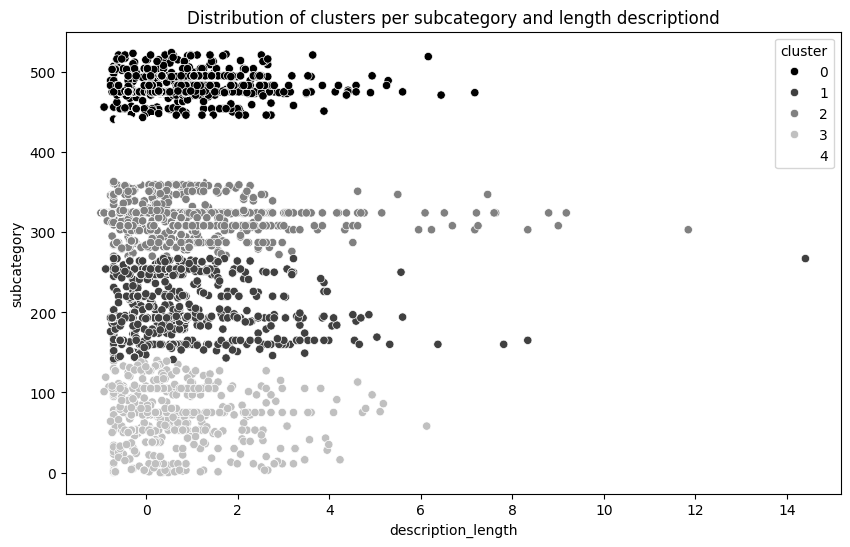

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# load data
df = pd.read_pickle("df_data.pkl")

# Ignoring unnecesarry columns
df = df.drop(columns=["reporter"], errors="ignore")

# new chars
def extract_platform(url):
    try:
        netloc_parts = urlparse(url).netloc.split(".")
        return netloc_parts[-2] if len(netloc_parts) >= 2 else "unknown"
    except:
        return "unknown"

df["source_platform"] = df["url"].apply(extract_platform)

def extract_crypto(addresses):
    try:
        parsed_addresses = eval(addresses)
        return ", ".join(parsed_addresses.keys()) if isinstance(parsed_addresses, dict) else "None"
    except:
        return "None"

df["crypto_used"] = df["addresses"].apply(extract_crypto)
df["description_length"] = df["description"].apply(lambda x: len(str(x)))
df["has_address"] = df["addresses"].apply(lambda x: 1 if pd.notna(x) else 0)

# codification of categorical variables
label_encoders = {}
categorical_columns = ["category", "subcategory", "source_platform", "crypto_used"]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Normalizing numericla data
scaler = StandardScaler()
df[["description_length"]] = scaler.fit_transform(df[["description_length"]])

# Model 1: classification of scam 
X = df.drop(columns=["category", "name", "url", "description", "addresses"], errors="ignore")
y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Clasification of scam type:")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(clf, "classification_model.pkl")

# model 2: prediction of scams with addresses
X = df.drop(columns=["has_address", "name", "url", "description", "addresses"], errors="ignore")
y = df["has_address"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
print("Prediction of scams per addresses:")
print(classification_report(y_test, y_pred2))

# save model
joblib.dump(clf2, "address_prediction_model.pkl")

# model 3: clustering for pattern detection
X_cluster = df.drop(columns=["name", "url", "description", "addresses", "category"], errors='ignore')
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X_cluster)
print("Clusters generated:")
print(df[["cluster", "category", "source_platform"]].head(10))

# save model
joblib.dump(kmeans, "clustering_model.pkl")

# VCluster visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["description_length"], y=df["subcategory"], hue=df["cluster"], palette="grey")
plt.title("Distribution of clusters per subcategory and length descriptiond")
plt.show()

# Método para importar en Power BI
def load_model(filename):
    return joblib.load(filename)

#use on powerbi
# model = load_model("classification_model.pkl")
# prediction = model.predict(new_data)